<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-and-Validate-Data" data-toc-modified-id="Load-and-Validate-Data-0.1">Load and Validate Data</a></span><ul class="toc-item"><li><span><a href="#Drop-Empties-/-NaN-rows-before-feature-development" data-toc-modified-id="Drop-Empties-/-NaN-rows-before-feature-development-0.1.1">Drop Empties / NaN rows before feature development</a></span></li><li><span><a href="#Build-Features-on-Trimmed-Dataframe" data-toc-modified-id="Build-Features-on-Trimmed-Dataframe-0.1.2">Build Features on Trimmed Dataframe</a></span></li></ul></li><li><span><a href="#Inspect-Outliers" data-toc-modified-id="Inspect-Outliers-0.2">Inspect Outliers</a></span></li><li><span><a href="#One-Hot-Encoding-for-Category-Column" data-toc-modified-id="One-Hot-Encoding-for-Category-Column-0.3">One-Hot Encoding for Category Column</a></span></li><li><span><a href="#Distribution-of-Target-Variable" data-toc-modified-id="Distribution-of-Target-Variable-0.4">Distribution of Target Variable</a></span><ul class="toc-item"><li><span><a href="#Target-Variable-=-play_count" data-toc-modified-id="Target-Variable-=-play_count-0.4.1">Target Variable = <code>play_count</code></a></span></li></ul></li><li><span><a href="#Correlations-between-Target-and-Feature-Columns" data-toc-modified-id="Correlations-between-Target-and-Feature-Columns-0.5">Correlations between Target and Feature Columns</a></span></li></ul></li><li><span><a href="#Adding-the-categoricals..." data-toc-modified-id="Adding-the-categoricals...-1">Adding the categoricals...</a></span><ul class="toc-item"><li><span><a href="#Misc-functions-(now-living-in-'features.py')" data-toc-modified-id="Misc-functions-(now-living-in-'features.py')-1.1">Misc functions (now living in 'features.py')</a></span></li></ul></li></ul></div>

In [71]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)

import pickle
import features
import copy

# from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()


import re
import string

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

In [36]:
# reload certain modules when changed
reload(features)

<module 'features' from '/Users/tk/Google Drive (thomaskavanagh.dev@gmail.com)/GitHub/regression-podcast-popularity/notebooks/features.py'>

## Load and Validate Data

In [37]:
df_version = 'merged_10-08_13-54.pickle'
import_path = '../scraped/merged/' + df_version
with open(import_path, 'rb') as file:
    raw_df = pickle.load(file)
    
print('shape of raw df: ', raw_df.shape)
# print('number of empty columns: ', df[df.ep_total == 0].shape)

shape of raw df:  (7777, 15)


In [38]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 0 to 59
Data columns (total 15 columns):
title                7777 non-null object
chan_url             7777 non-null object
num_comments         7777 non-null int64
author               7777 non-null object
isExplicit           7777 non-null int64
sub_count            7777 non-null int64
play_count           7777 non-null int64
ch_feed-socials      7777 non-null object
ep_total             7777 non-null int64
recent_eps           7759 non-null object
hover_text_concat    7759 non-null object
chan_desc            7759 non-null object
cover_img_url        7759 non-null object
first_release        7777 non-null object
category             7777 non-null object
dtypes: int64(5), object(10)
memory usage: 972.1+ KB


### Drop Empties / NaN rows before feature development

In [39]:
raw_df.dropna(inplace=True)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7759 entries, 0 to 59
Data columns (total 15 columns):
title                7759 non-null object
chan_url             7759 non-null object
num_comments         7759 non-null int64
author               7759 non-null object
isExplicit           7759 non-null int64
sub_count            7759 non-null int64
play_count           7759 non-null int64
ch_feed-socials      7759 non-null object
ep_total             7759 non-null int64
recent_eps           7759 non-null object
hover_text_concat    7759 non-null object
chan_desc            7759 non-null object
cover_img_url        7759 non-null object
first_release        7759 non-null object
category             7759 non-null object
dtypes: int64(5), object(10)
memory usage: 969.9+ KB


We should remove any rows with 0 episodes.

In [40]:
raw_df[raw_df.ep_total == 0].sort_values('recent_eps',ascending=False)[['ep_total', 'recent_eps']]

,ep_total,recent_eps
47,0,"[[2019-10-02, 00:54:20, 4], [2019-09-25, 00:57..."
45,0,"[[2019-09-24, 00:45:52, 0], [2019-09-10, 00:47..."
46,0,"[[2019-09-24, 00:21:38, 2], [2019-09-17, 00:26..."
48,0,[]
87,0,[]
...,...,...
58,0,[]
56,0,[]
52,0,[]
44,0,[]


We should remove these rows. Three seem like scraping errors, but for now let's chuck them.

In [41]:
# for EDA, mask entries where no episodes have been logged
df = raw_df[raw_df['ep_total'] != 0].copy()

# Build features into new dataframe
df = features.build_features(df);

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [42]:
df.shape

(7658, 24)

In [25]:
df.sort_values(by='twitter_followers',ascending=False).head()

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed-socials,ep_total,recent_eps,...,category,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_age,has_twitter,has_facebook,has_youtube,has_instagram,twitter_followers
4,Ellen on the Go,https://castbox.fm/channel/Ellen-on-the-Go-id1...,86,WAD Productions | Wondery,0,76627,1096542,"[https://twitter.com/TheEllenShow, https://www...",93,"[[2019-10-03, 00:31:42, 0], [2019-10-01, 00:37...",...,TV & Film,10.3,0.2,218.8,393.0,1,1,1,1,78705541
6,Conan O’Brien Needs A Friend,https://castbox.fm/channel/Conan-O’Brien-Needs...,810,Team Coco & Earwolf,1,159357,3147191,"[https://twitter.com/ConanOBrien, https://www....",51,"[[2019-09-30, 01:00:24, 8], [2019-09-23, 01:02...",...,Comedy,6.9,0.1,216.6,362.0,1,1,0,0,28596195
28,WSJ Your Money Briefing,https://castbox.fm/channel/WSJ-Your-Money-Brie...,7,The Wall Street Journal,0,11072,336435,"[https://twitter.com/WSJ, https://www.facebook...",332,"[[2019-10-04, 00:07:54, 0], [2019-10-03, 00:10...",...,Business,1.2,0.8,215.9,428.0,1,1,0,0,16941694
46,The Dropout,https://castbox.fm/channel/The-Dropout-id1957535,156,ABC News,0,221130,867818,"[https://twitter.com/ABC, https://www.facebook...",7,"[[2019-02-26, 00:39:31, 160], [2019-02-19, 00:...",...,Games & Hobbies,7.0,0.2,217.7,42.0,1,1,0,1,14589091
74,Under The Skin with Russell Brand,https://castbox.fm/channel/Under-The-Skin-with...,149,Russell Brand,1,139162,1090617,"[https://twitter.com/rustyrockets, https://www...",89,"[[2019-09-13, 01:17:32, 26], [2019-06-21, 01:2...",...,Comedy,17.9,0.1,216.9,923.0,1,1,0,0,11640578


### Build Features on Trimmed Dataframe

In [10]:
# list of all numeric columns suitable for regression
reg_cols = (['title','num_comments','isExplicit',
             'sub_count','play_count','ep_total',
             'recent_ep_spacing','lifetime_ep_freq', 'avg_ep_len',
             'twitter', 'facebook','youtube','instagram'])

df[reg_cols].sample(5)

KeyError: "['facebook', 'twitter', 'instagram', 'youtube'] not in index"

In [43]:
df.describe()

,num_comments,isExplicit,sub_count,play_count,ep_total,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_age,has_twitter,has_facebook,has_youtube,has_instagram,twitter_followers
count,7658.0,7658.0,7658.0,7658.0,7658.0,7578.0,7658.0,7623.0,7658.0,7658.0,7658.0,7658.0,7658.0,7658.0
mean,17.0,0.2,6457.9,123532.5,136.5,15.8,0.2,217.7,928.2,0.2,0.1,0.0,0.0,106791.9
std,265.8,0.4,45248.8,1154583.3,275.5,30.1,1.1,1.4,1187.8,0.4,0.3,0.2,0.2,1279322.5
min,0.0,0.0,0.0,0.0,1.0,0.0,0.0,211.7,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,33.0,286.0,18.0,6.2,0.1,216.8,189.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,250.0,3341.5,60.0,7.7,0.1,217.7,607.0,0.0,0.0,0.0,0.0,0.0
75%,3.8,0.0,1567.2,25960.2,157.0,15.6,0.2,218.6,1310.0,0.0,0.0,0.0,0.0,0.0
max,21769.0,1.0,2262375.0,76019418.0,4998.0,1249.5,61.0,223.3,18176.0,1.0,1.0,1.0,1.0,78705541.0


## Inspect Outliers

In [ ]:
outlier_cols = (['title', 'chan_url', 'author',
             'sub_count','play_count','ep_total', 'avg_ep_len','num_comments'])

In [ ]:
pd.set_option('display.max_colwidth', 100)
# podcasts with over 10 million plays
df[df.play_count > 10000000.0].sort_values('play_count', ascending=False)[outlier_cols]

After sifting through the most popular podcasts, subscriber and playcount numbers seem reasonable. Joe Rogan's podcast is insanely popular. It probably should be categorized as an outlier.

Now, let's look at the low end. We should probably throw out any podcasts with under 50 plays.

In [ ]:
pd.set_option('display.max_colwidth', 100)
# podcasts with over a million plays
df[df.play_count < 50].sort_values('play_count', ascending=True)[outlier_cols]

In [44]:
trim_df = df.loc[(df.play_count < 10000000.0) & (df.play_count > 50)]
trim_df.shape

(6553, 24)

## One-Hot Encoding for Category Column

In [45]:
trim_df.category.unique()

array(['Management ', 'Investing', 'Books', 'Fashion & Beauty', 'Games',
       'Courses', 'Religion & Spirituality', 'Music', 'Christianity',
       'Non-profit', 'Standup', 'Performing Arts', 'Entertainment News',
       'Medicine', 'Home & Garden', 'Crafts', 'Games & Hobbies',
       'Education for Kids', 'Comedy Fiction', 'Comedy', 'Daily News',
       'Design', 'Fiction', 'News', 'Music Interviews',
       'Language Learning', 'Society & Culture', 'Hobbies', 'Sexuality',
       'Health', 'Pets & Animals', 'Education', 'Music History',
       'Government', 'Science Fiction', 'Fitness', 'Alternative Health',
       'Sports News', 'Self-Improvement', 'Parenting', 'Politics',
       'Careers', 'Nutrition', 'Comedy Interviews', 'Kids & Family',
       'Mental Health', 'Aviation', 'Animation & Manga',
       'Stories for Kids', 'News & Politics', 'History', 'Buddhism',
       'Automotive', 'Business News', 'Health & Fitness', 'Technology',
       'Video Games', 'Visual Arts', 'Drama', '

In [46]:
pattern = re.compile('[\W_]+')
trim_df['category'] = trim_df.category.apply(lambda x: re.sub(r'\W+', '_', x))
trim_df.category.unique()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array(['Management_', 'Investing', 'Books', 'Fashion_Beauty', 'Games',
       'Courses', 'Religion_Spirituality', 'Music', 'Christianity',
       'Non_profit', 'Standup', 'Performing_Arts', 'Entertainment_News',
       'Medicine', 'Home_Garden', 'Crafts', 'Games_Hobbies',
       'Education_for_Kids', 'Comedy_Fiction', 'Comedy', 'Daily_News',
       'Design', 'Fiction', 'News', 'Music_Interviews',
       'Language_Learning', 'Society_Culture', 'Hobbies', 'Sexuality',
       'Health', 'Pets_Animals', 'Education', 'Music_History',
       'Government', 'Science_Fiction', 'Fitness', 'Alternative_Health',
       'Sports_News', 'Self_Improvement', 'Parenting', 'Politics',
       'Careers', 'Nutrition', 'Comedy_Interviews', 'Kids_Family',
       'Mental_Health', 'Aviation', 'Animation_Manga', 'Stories_for_Kids',
       'News_Politics', 'History', 'Buddhism', 'Automotive',
       'Business_News', 'Health_Fitness', 'Technology', 'Video_Games',
       'Visual_Arts', 'Drama', 'News_Commentary', 'I

In [58]:
dummies = pd.get_dummies(trim_df.category)
dummies.head(3)

,Alternative_Health,Animation_Manga,Arts,Automotive,Aviation,Books,Buddhism,Business,Business_News,Careers,...,Sexuality,Society_Culture,Sports_News,Standup,Stories_for_Kids,TV_Film,Tech_News,Technology,Video_Games,Visual_Arts
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
for col in dummies.columns:
    trim_df['d_'+col] = dummies[col]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
dummies_names = ['d_'+col for col in dummies]
dummies_names

['d_Arts',
 'd_Books',
 'd_Business',
 'd_Careers',
 'd_Comedy',
 'd_Design',
 'd_Education',
 'd_Fashion_Beauty',
 'd_Food',
 'd_Games_Hobbies',
 'd_Health',
 'd_Kids_Family',
 'd_Music',
 'd_News_Politics',
 'd_Performing_Arts',
 'd_Religion_Spirituality',
 'd_Society_Culture',
 'd_TV_Film',
 'd_Technology',
 'd_Visual_Arts']

In [49]:
trim_df.columns

Index(['title', 'chan_url', 'num_comments', 'author', 'isExplicit',
       'sub_count', 'play_count', 'ch_feed-socials', 'ep_total', 'recent_eps',
       'hover_text_concat', 'chan_desc', 'cover_img_url', 'first_release',
       'category', 'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len',
       'chan_age', 'has_twitter', 'has_facebook', 'has_youtube',
       'has_instagram', 'twitter_followers', 'd_Alternative_Health',
       'd_Animation_Manga', 'd_Arts', 'd_Automotive', 'd_Aviation', 'd_Books',
       'd_Buddhism', 'd_Business', 'd_Business_News', 'd_Careers',
       'd_Christianity', 'd_Comedy', 'd_Comedy_Fiction', 'd_Comedy_Interviews',
       'd_Courses', 'd_Crafts', 'd_Daily_News', 'd_Design', 'd_Drama',
       'd_Education', 'd_Education_for_Kids', 'd_Entertainment_News',
       'd_Entrepreneurship', 'd_Fashion_Beauty', 'd_Fiction', 'd_Fitness',
       'd_Food', 'd_Games', 'd_Games_Hobbies', 'd_Government', 'd_Health',
       'd_Health_Fitness', 'd_Hinduism', 'd_History',

In [51]:
trim_df.sort_values(by='twitter_followers',ascending=False)[5:8]

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed-socials,ep_total,recent_eps,...,d_Sexuality,d_Society_Culture,d_Sports_News,d_Standup,d_Stories_for_Kids,d_TV_Film,d_Tech_News,d_Technology,d_Video_Games,d_Visual_Arts
22,TIME's The Brief,https://castbox.fm/channel/TIME's-The-Brief-id...,0,Time,0,1630,87364,"[https://twitter.com/TIME, http://time.com/new...",1215,"[[2019-10-08, 00:08:11, 0], [2019-10-07, 00:46...",...,0,0,0,0,0,0,0,0,0,0
25,TIME's Top Stories,https://castbox.fm/channel/TIME's-Top-Stories-...,2,time.com,0,8406,387972,"[https://twitter.com/time, https://www.faceboo...",500,"[[2019-10-07, 00:07:39, 0], [2019-10-07, 00:05...",...,0,0,0,0,0,0,0,0,0,0
46,The Dropout,https://castbox.fm/channel/The-Dropout-id1957535,156,ABC News,0,221130,867818,"[https://twitter.com/ABC, https://www.facebook...",7,"[[2019-02-26, 00:39:31, 160], [2019-02-19, 00:...",...,0,0,0,0,0,0,0,0,0,0


## Distribution of Target Variable
### Target Variable = `play_count`

In [52]:
trim_df.play_count.describe()

count      6553.0
mean     110309.5
std      483764.4
min          51.0
25%         949.0
50%        5937.0
75%       36596.0
max     9283120.0
Name: play_count, dtype: float64

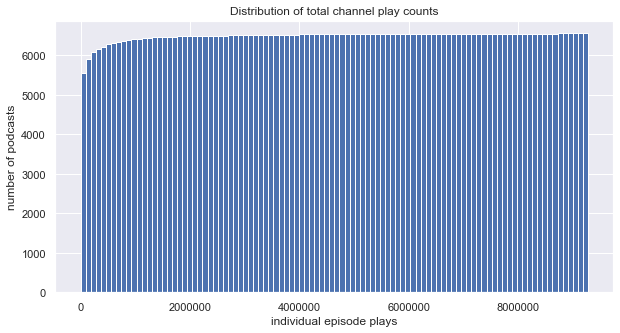

In [53]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Distribution of total channel play counts')
plt.xlabel('individual episode plays')
plt.ylabel('number of podcasts')
plt.hist(trim_df.play_count, bins=100, log=False,cumulative=True); 

Ok, so the distribution of play counts is heavily left-skewed, with ~75% of podcasts having less than 120,000 plays. Let's zoom in on the bottom 75%.

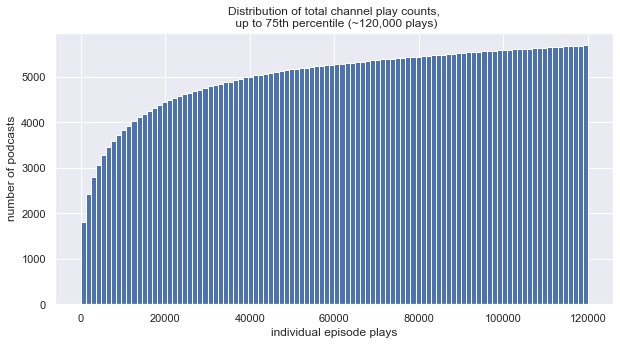

In [54]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Distribution of total channel play counts,\n up to 75th percentile (~120,000 plays)')
plt.xlabel('individual episode plays')
plt.ylabel('number of podcasts')
plt.hist(trim_df.play_count, bins=100, log=False,cumulative=True, range=[0,120000]); 

Let's do the same for subscribers.

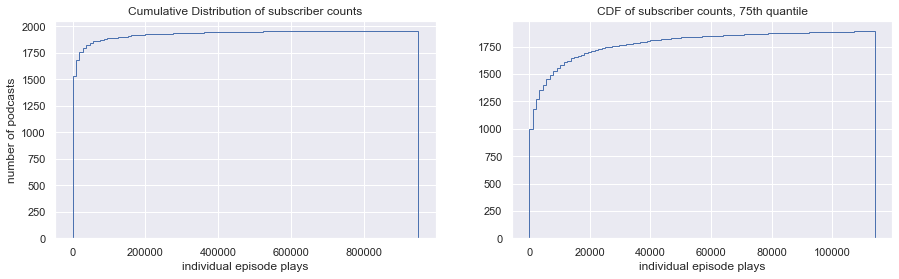

In [218]:
plt.subplots(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.title('Cumulative Distribution of subscriber counts')
plt.xlabel('individual episode plays')
plt.ylabel('number of podcasts')
plt.hist(trim_df.sub_count, bins=100, log=False,cumulative=True, histtype='step'); 

# now just plot for the bottom 75%
plt.subplot(1, 2, 2)
# get 75th percentile value
sub_75_q = trim_df.play_count.quantile(0.75)
plt.title('CDF of subscriber counts, 75th quantile')
plt.xlabel('individual episode plays')
plt.hist(trim_df.sub_count, bins=100, log=False,cumulative=True, range=[0,sub_75_q],  histtype='step'); 



Play count and subscriber count have very similar CDFs. And naturally they are very strongly correlated:

In [220]:
np.corrcoef(x = trim_df.play_count, y = trim_df.sub_count)

array([[1.        , 0.85748055],
       [0.85748055, 1.        ]])

## Correlations between Target and Feature Columns

In [222]:
reg_cols

['title',
 'num_comments',
 'isExplicit',
 'sub_count',
 'play_count',
 'ep_total',
 'recent_ep_spacing',
 'lifetime_ep_freq',
 'avg_ep_len',
 'twitter',
 'facebook',
 'youtube',
 'instagram']

In [236]:
pair_plot = (['num_comments', 'isExplicit', 'sub_count', 'ep_total',
               'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len',
               'twitter', 'facebook', 'youtube', 'instagram', 'play_count'])
# numericals.extend(dummies_names)

//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


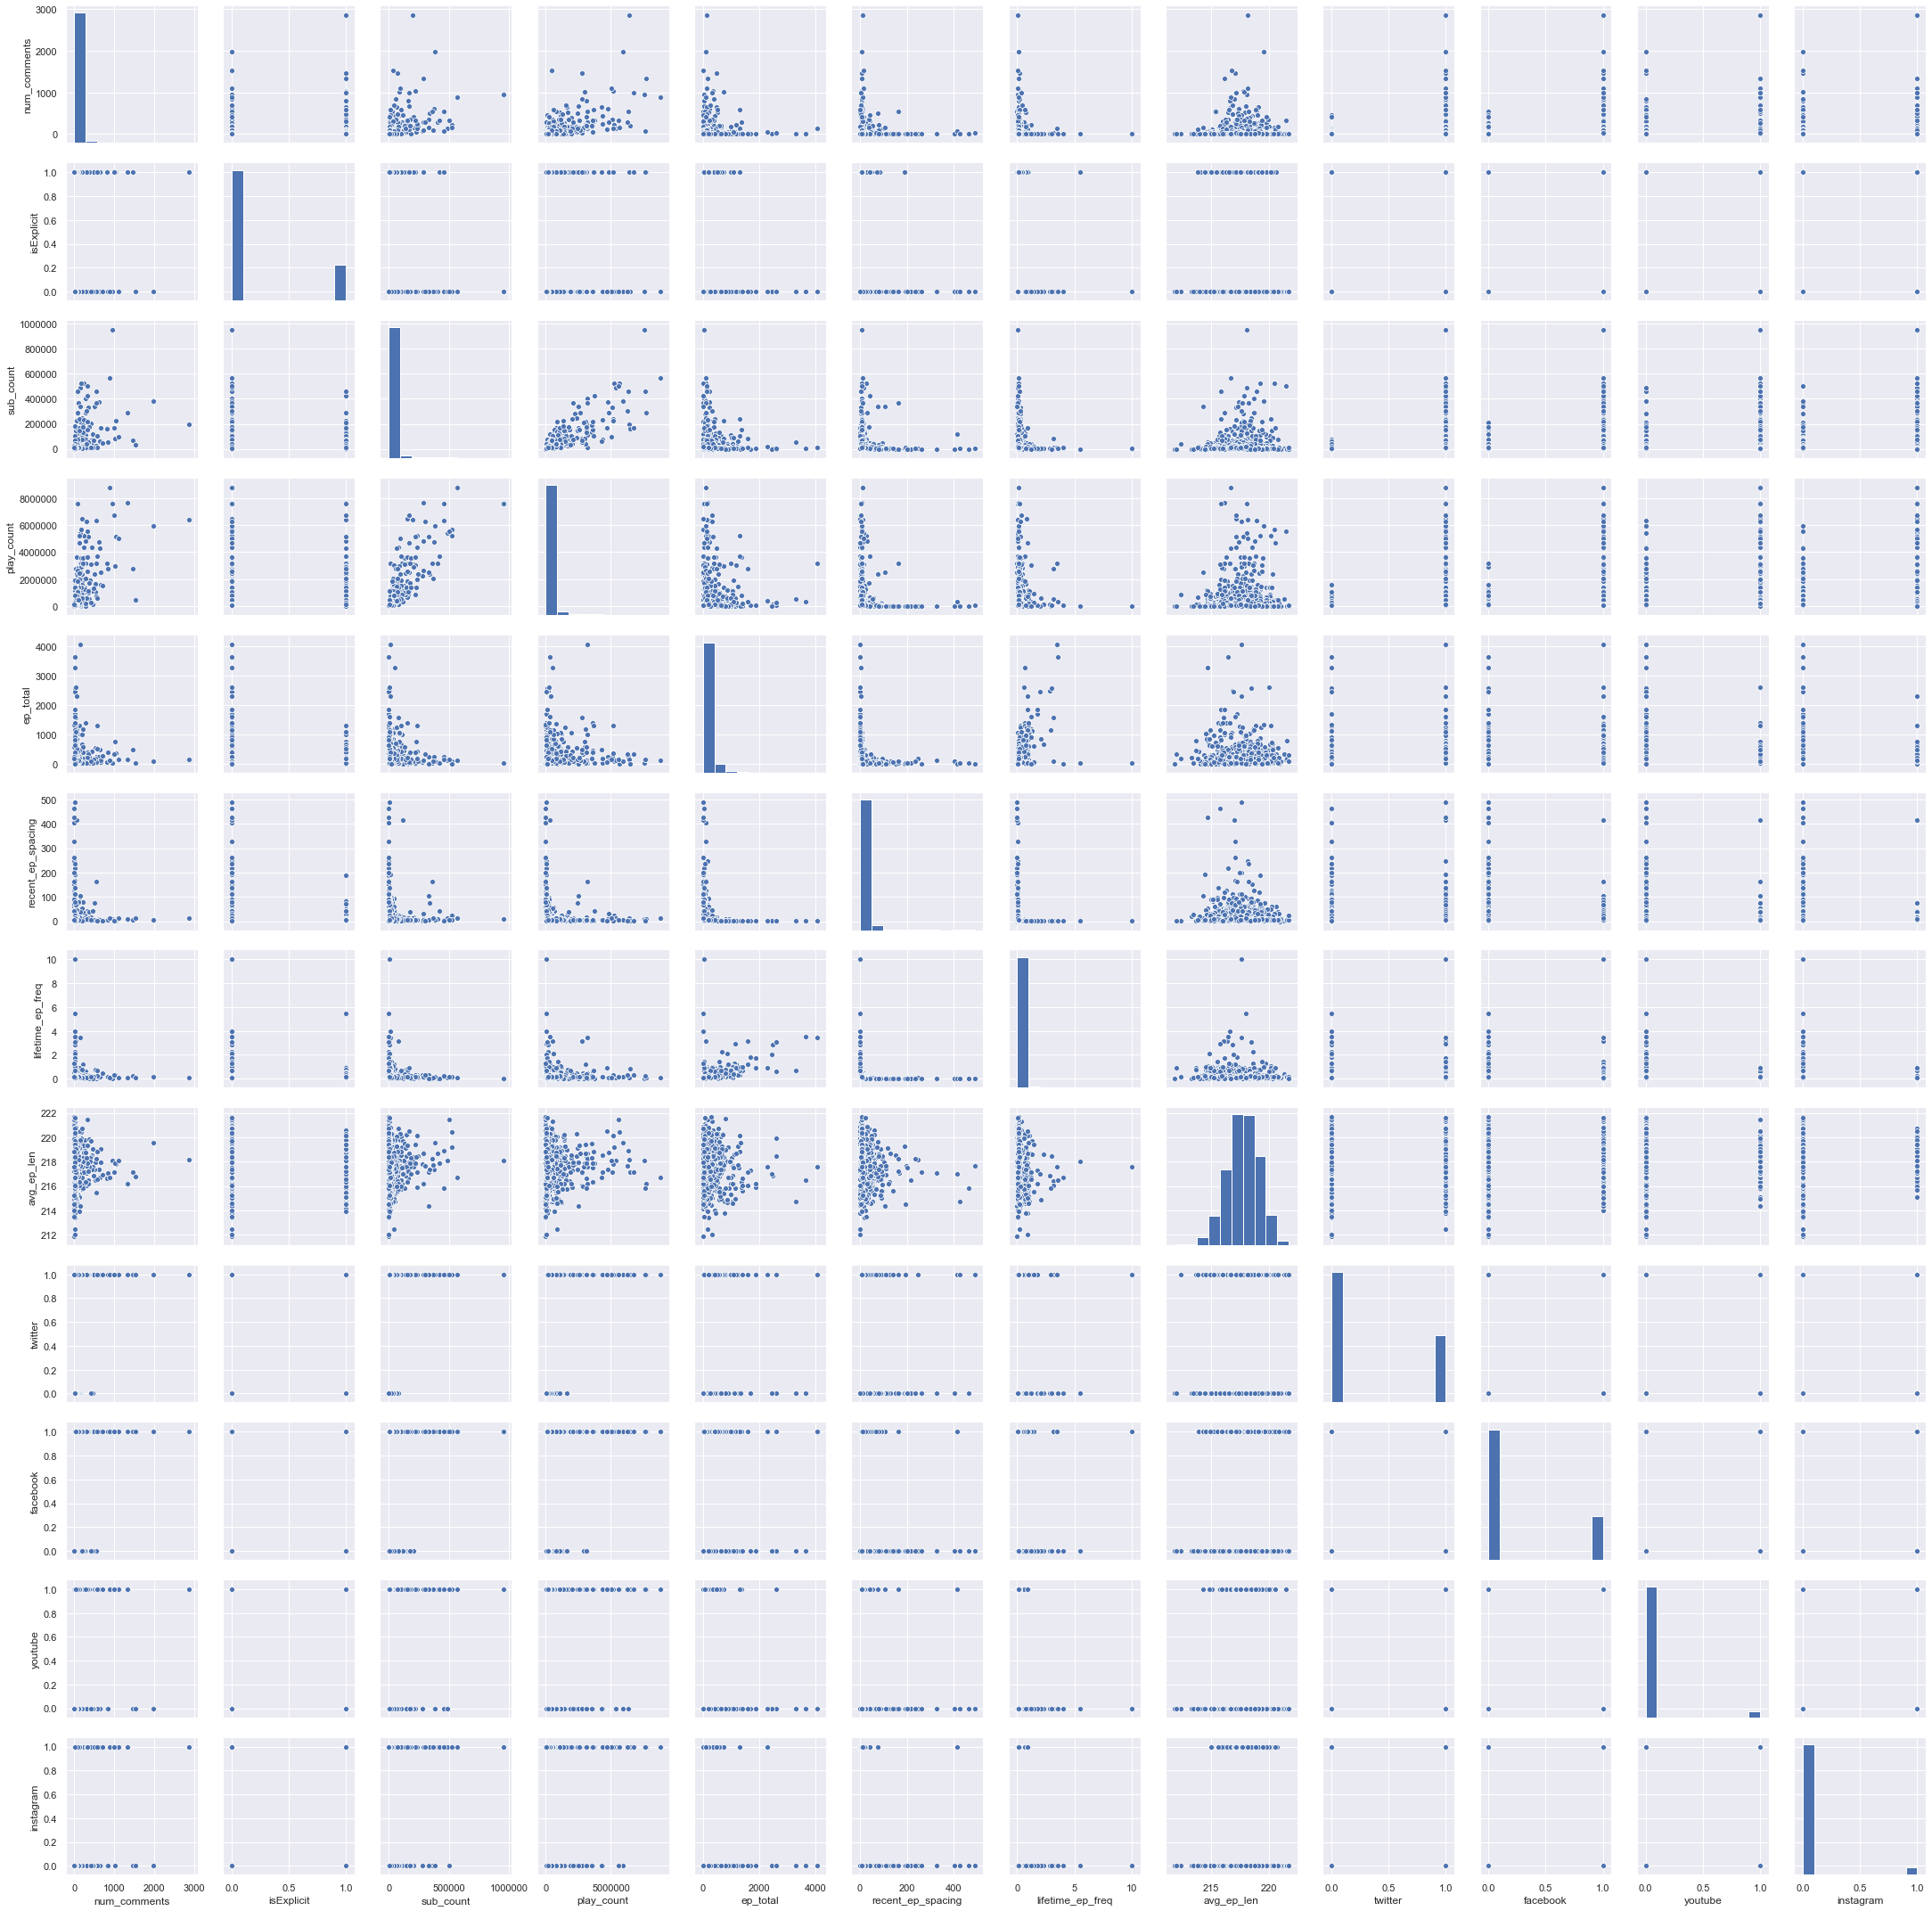

In [237]:
sns.pairplot(trim_df[numericals])

In [65]:
def calc_avg_desc_len(hover_text):
    
    try:
        ep_desc_list = hover_text.split('|')
#     print(ep_desc_list)
        return np.mean([len(d) for d in ep_desc_list])
    except:
        return 0

In [ ]:
reg_df = trim_df.dropna()

In [66]:
reg_df['avg_ep_desc_len'] = reg_df.hover_text_concat.apply(calc_avg_desc_len)
reg_df['chan_desc_len'] = reg_df.chan_desc.apply(lambda x: len(x))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6515 entries, 0 to 57
Data columns (total 98 columns):
title                      6515 non-null object
chan_url                   6515 non-null object
num_comments               6515 non-null int64
author                     6515 non-null object
isExplicit                 6515 non-null int64
sub_count                  6515 non-null int64
play_count                 6515 non-null int64
ch_feed-socials            6515 non-null object
ep_total                   6515 non-null int64
recent_eps                 6515 non-null object
hover_text_concat          6515 non-null object
chan_desc                  6515 non-null object
cover_img_url              6515 non-null object
first_release              6515 non-null object
category                   6515 non-null object
recent_ep_spacing          6515 non-null float64
lifetime_ep_freq           6515 non-null float64
avg_ep_len                 6515 non-null float64
chan_age                   6515 n

In [68]:
reg_cols = ['isExplicit', 'ep_total',
       'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len', 'chan_age',
       'has_twitter', 'has_facebook', 'has_youtube', 'has_instagram', 'twitter_followers',
       'chan_desc_len', 'avg_ep_desc_len']

# sub_count is currently withheld from regression

In [72]:
# predictors
X = reg_df[reg_cols]

# target
y = reg_df.play_count

In [73]:
X_non_test, X_test, y_non_test, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_non_test, y_non_test, test_size=0.2,random_state=42)

In [75]:
simple_lr = LinearRegression()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Ridge model
ridge_reg = Ridge(alpha = 10000)

In [76]:
#validate

simple_lr.fit(X_train, y_train)
print(f'Linear Regression val R^2: {simple_lr.score(X_val, y_val):.3f}')

ridge_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {ridge_reg.score(X_val_scaled, y_val):.3f}')

Linear Regression val R^2: 0.226
Ridge Regression val R^2: 0.189


In [77]:
for z in zip(reg_cols, simple_lr.coef_):
    print(z)

('isExplicit', 28808.062478724452)
('ep_total', 128.8399776464532)
('recent_ep_spacing', -418.90007174715294)
('lifetime_ep_freq', -3101.524732307808)
('avg_ep_len', -1391.6914496287527)
('chan_age', -4.907557353924318)
('has_twitter', 90238.60192457635)
('has_facebook', 337746.86735542864)
('has_youtube', 386009.22475506534)
('has_instagram', 341924.07408365613)
('twitter_followers', 0.0037783531131442257)
('chan_desc_len', -7.644725289019133)
('avg_ep_desc_len', -7.447115481072697)


In [78]:
for z in zip(reg_cols, ridge_reg.coef_):
    print(z)

('isExplicit', 4574.754443852175)
('ep_total', 13672.857366026352)
('recent_ep_spacing', -5300.792146358295)
('lifetime_ep_freq', 440.4560390846765)
('avg_ep_len', -601.2979888137581)
('chan_age', 3897.0352967672898)
('has_twitter', 33934.632817377176)
('has_facebook', 44554.61879325677)
('has_youtube', 36072.80158034561)
('has_instagram', 36223.60268469454)
('twitter_followers', 7072.501489531565)
('chan_desc_len', -1659.3384018039799)
('avg_ep_desc_len', -2973.602110266969)


In [79]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [140]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [141]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.099
Ridge Regression val R^2: 0.097
Degree 2 polynomial regression val R^2: -2.490


In [142]:
for z in zip(poly.get_feature_names(), lm_poly.coef_):
    print(z)

('1', 4952.8896566812155)
('x0', -3323.8923485000255)
('x1', 25122.06535925637)
('x2', 80509.5408748928)
('x3', 5822.781897463439)
('x4', -9575.53983178816)
('x5', -2870.1935596269495)
('x6', -8502.66325783006)
('x7', -12983.87829203984)
('x8', -4508.5938110529705)
('x9', -7752.274716106541)
('x10', -11.67147659266)
('x11', 606.9996184162753)
('x12', 1372.5651567779444)
('x13', 1336.6772624009018)
('x14', 251.5700733880959)
('x15', 40.05741894248537)
('x16', 1428.9949831777924)
('x17', -838.2335000812859)
('x18', 78.09642947872625)
('x19', 197.56000151738053)
('x20', 3602.175401258906)
('x21', 1732.0310082892279)
('x22', -16.322297631479014)
('x23', -131.43471866617844)
('x24', -2240.0359926034744)
('x25', -538.8299904529972)
('x26', -1138.858687872042)
('x27', -1308.3133059539477)
('x28', -292.91677786880865)
('x29', -5086.636859973593)
('x30', 1141.847371830805)
('x31', -970.8128321071354)
('x32', 1042.4856714808095)
('x33', -1292.649468566198)
('x34', 714.9386620185579)
('x35', -172

('x39 x60', 0.0)
('x39 x61', 0.0)
('x39 x62', 0.0)
('x39 x63', 0.0)
('x39 x64', 0.0)
('x39 x65', 0.0)
('x39 x66', 0.0)
('x39 x67', 0.0)
('x39 x68', 0.0)
('x39 x69', 0.0)
('x39 x70', 0.0)
('x39 x71', 0.0)
('x39 x72', 0.0)
('x39 x73', 0.0)
('x39 x74', 0.0)
('x39 x75', 0.0)
('x39 x76', 0.0)
('x39 x77', 0.0)
('x39 x78', 0.0)
('x39 x79', 0.0)
('x39 x80', 0.0)
('x39 x81', 0.0)
('x39 x82', 0.0)
('x39 x83', 0.0)
('x39 x84', 0.0)
('x40^2', 516.562273365956)
('x40 x41', 0.0)
('x40 x42', 0.0)
('x40 x43', 0.0)
('x40 x44', 0.0)
('x40 x45', 0.0)
('x40 x46', 0.0)
('x40 x47', 0.0)
('x40 x48', 0.0)
('x40 x49', 0.0)
('x40 x50', 0.0)
('x40 x51', 0.0)
('x40 x52', 0.0)
('x40 x53', 0.0)
('x40 x54', 0.0)
('x40 x55', 0.0)
('x40 x56', 0.0)
('x40 x57', 0.0)
('x40 x58', 0.0)
('x40 x59', 0.0)
('x40 x60', 0.0)
('x40 x61', 0.0)
('x40 x62', 0.0)
('x40 x63', 0.0)
('x40 x64', 0.0)
('x40 x65', 0.0)
('x40 x66', 0.0)
('x40 x67', 0.0)
('x40 x68', 0.0)
('x40 x69', 0.0)
('x40 x70', 0.0)
('x40 x71', 0.0)
('x40 x72', 0.0)
('x

# Adding the categoricals...

In [95]:
reg_and_cat_cols = ['isExplicit', 'ep_total',
       'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len', 'chan_age',
       'has_twitter', 'has_facebook', 'has_youtube', 'has_instagram', 'twitter_followers',
       'chan_desc_len', 'avg_ep_desc_len','d_Alternative_Health',
       'd_Animation_Manga', 'd_Arts', 'd_Automotive', 'd_Aviation', 'd_Books',
       'd_Buddhism', 'd_Business', 'd_Business_News', 'd_Careers',
       'd_Christianity', 'd_Comedy', 'd_Comedy_Fiction', 'd_Comedy_Interviews',
       'd_Courses', 'd_Crafts', 'd_Daily_News', 'd_Design', 'd_Drama',
       'd_Education', 'd_Education_for_Kids', 'd_Entertainment_News',
       'd_Entrepreneurship', 'd_Fashion_Beauty', 'd_Fiction', 'd_Fitness',
       'd_Food', 'd_Games', 'd_Games_Hobbies', 'd_Government', 'd_Health',
       'd_Health_Fitness', 'd_Hinduism', 'd_History', 'd_Hobbies',
       'd_Home_Garden', 'd_How_to', 'd_Improv', 'd_Investing', 'd_Kids_Family',
       'd_Language_Learning', 'd_Leisure', 'd_Management_', 'd_Marketing',
       'd_Medicine', 'd_Mental_Health', 'd_Music', 'd_Music_Commentary',
       'd_Music_History', 'd_Music_Interviews', 'd_News', 'd_News_Commentary',
       'd_News_Politics', 'd_Non_profit', 'd_Nutrition', 'd_Parenting',
       'd_Performing_Arts', 'd_Pets_Animals', 'd_Politics',
       'd_Religion_Spirituality', 'd_Science_Fiction', 'd_Self_Improvement',
       'd_Sexuality', 'd_Society_Culture', 'd_Sports_News', 'd_Standup',
       'd_Stories_for_Kids', 'd_TV_Film', 'd_Tech_News', 'd_Technology',
       'd_Video_Games', 'd_Visual_Arts']

In [128]:
# predictors
X = reg_df[reg_and_cat_cols]

# target
y = reg_df.play_count

In [129]:
X_non_test, X_test, y_non_test, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_non_test, y_non_test, test_size=0.2,random_state=42)

In [130]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=10000)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=3) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [131]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 3 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.099
Ridge Regression val R^2: 0.248


KeyboardInterrupt: 

In [126]:
for z in zip(reg_cols, lm.coef_):
    print(z)

AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [125]:
for z in zip(reg_cols, lm_reg.coef_):
    print(z)

('isExplicit', -3497.775606301887)
('ep_total', 35180.12730746869)
('recent_ep_spacing', -3576.751854231736)
('lifetime_ep_freq', -3827.949990499497)
('avg_ep_len', -1277.3692519636163)
('chan_age', 4487.7903841009)
('has_twitter', 6976.09783844351)
('has_facebook', 79851.43914315561)
('has_youtube', 80317.35891040835)
('has_instagram', 24090.54321124317)
('twitter_followers', 22322.409541374924)
('chan_desc_len', -3650.8658225087042)
('avg_ep_desc_len', -1784.0383444267636)
('d_Alternative_Health', -6819.857877871809)
('d_Animation_Manga', -5360.312545723223)
('d_Arts', -3631.0674095824497)
('d_Automotive', -9752.91747656197)
('d_Aviation', -6054.319571582707)
('d_Books', -5524.969349839298)
('d_Buddhism', -5689.224482972361)
('d_Business', 17574.391185160563)
('d_Business_News', -6337.4823284791855)
('d_Careers', -8380.275122523184)
('d_Christianity', -3091.1249974108405)
('d_Comedy', 70608.55413799197)
('d_Comedy_Fiction', -8030.935995863408)
('d_Comedy_Interviews', -8937.8422555411

In [114]:
from sklearn.model_selection import KFold

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [120]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=100)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.44526729573745455, 0.25968109180641497, 0.37212999701729954, 0.3775286190209608, 0.11412817571145206]
Ridge scores:  [0.4436193315030266, 0.2618634869087536, 0.37587511987196853, 0.3748007182059203, 0.12294431394681371] 

Simple mean cv r^2: 0.314 +- 0.116
Ridge mean cv r^2: 0.316 +- 0.113


In [121]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.402


In [122]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.38585721, 0.1990424 , 0.33875097, 0.46160783, 0.19527623])

In [123]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.4452673 , 0.25968109, 0.37213   , 0.37752862, 0.11412818])

In [124]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.34026688604052846
0.34471258368121915


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.96049e-17): result may not be accurate.
  overwrite_a=True).T
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.91024e-17): result may not be accurate.
  overwrite_a=True).T
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.127e-17): result may not be accurate.
  overwrite_a=True).T
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.49704e-17): result may not be accurate.
  overwrite_a=True).T


## Misc functions (now living in 'features.py')

In [25]:
def try_casting_to_int(ep_total):
    '''
    
    Corrects for an early scraping error when I wasn't properly casting ep_total to an int.
    
    '''
    try:
        return int(ep_total)
    except:
        return 0
    


def sanitize(df):
    '''
    
    General sanitization as I find errors with various datasets.
    
    '''
    
    
    
    df['ep_total'] = df.ep_total.apply(try_casting_to_int)
    

In [15]:
def build_features(df):
    '''
    
    Build feature columns, from methods in features.py.
    
    '''    
    
    df['recent_ep_spacing'] = df.recent_eps.apply(ft.recent_ep_mean_dist)
    df['lifetime_ep_freq'] = df.apply(ft.lifetime_ep_freq, axis=1)
    df['avg_ep_len'] = df.recent_eps.apply(ft.avg_ep_len)
    
    social_domains = ['twitter', 'facebook', 'youtube', 'instagram']
    for domain in social_domains:
        df[domain] = df['ch_feed-socials'].apply(ft.has_domain,social_domain=domain)
    
    return df